In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Data directories
ripe_dir = '/kaggle/input/fruit-ripeness-classification/Ripe Durian'
unripe_dir = '/kaggle/input/fruit-ripeness-classification/Unripe Durian'

# Image size for the model
image_size = (128, 128)  # Resize images to 128x128

# Initialize lists to hold images and labels
images = []
labels = []

# Function to load images and labels
def load_images_from_dir(directory, label):
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
        labels.append(label)

# Load Ripe and Unripe Durian images
load_images_from_dir(ripe_dir, label=1)  # Ripe Durian labeled as 1
load_images_from_dir(unripe_dir, label=0)  # Unripe Durian labeled as 0

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images (scaling pixel values to [0, 1])
images = images / 255.0

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create data generators for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()  # No augmentation for validation

In [4]:
# Count the number of ripe (1) and unripe (0) durian images
num_ripe = np.sum(labels == 1)
num_unripe = np.sum(labels == 0)

print(f"Number of ripe durian images: {num_ripe}")
print(f"Number of unripe durian images: {num_unripe}")

print(f"Number of training images: {len(X_train)}")
print(f"Number of validation images: {len(X_val)}")
print(f"Number of test images: {len(X_test)}")

Number of ripe durian images: 908
Number of unripe durian images: 718
Number of training images: 1138
Number of validation images: 244
Number of test images: 244


In [5]:
# Model architecture: CNN for binary classification with padding='same'
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size[0], image_size[1], 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output layer (0 or 1)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary crossentropy for binary classification
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

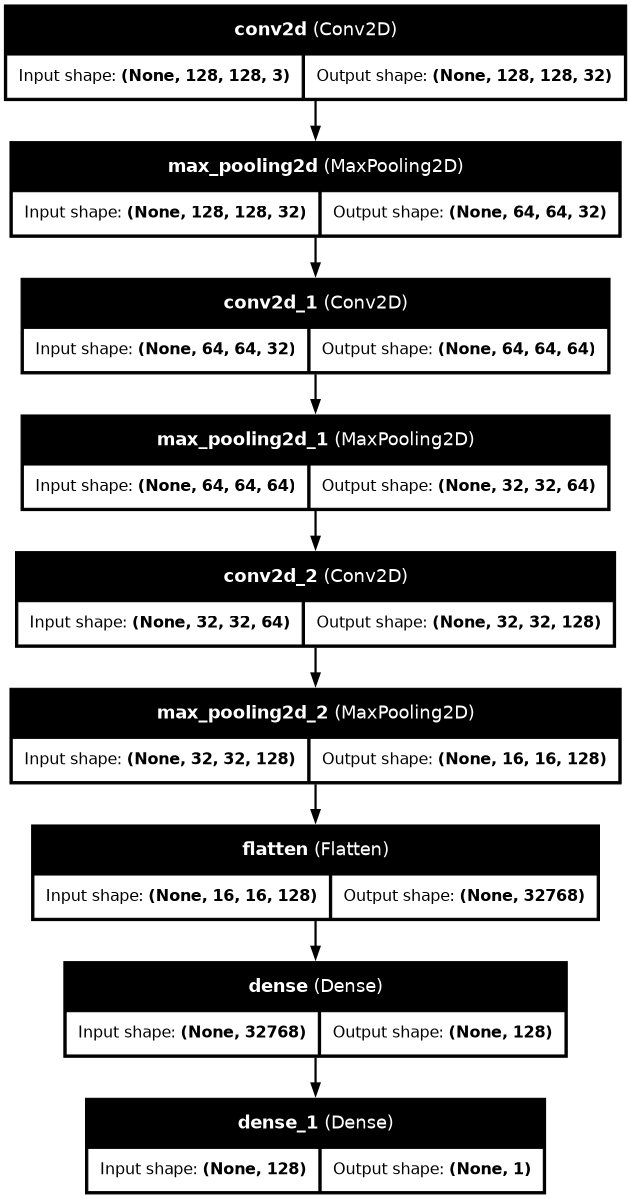

In [6]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, dpi=80)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model using the data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val)

# Define EarlyStopping with patience of 3
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               verbose=1,
                               restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Adjust the number of epochs as needed
    verbose=1,
    # callbacks=[early_stopping]
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 749ms/step - accuracy: 0.6196 - loss: 0.6799 - val_accuracy: 0.7951 - val_loss: 0.4972
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 706ms/step - accuracy: 0.8653 - loss: 0.3511 - val_accuracy: 0.8361 - val_loss: 0.3755
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 684ms/step - accuracy: 0.8735 - loss: 0.3064 - val_accuracy: 0.8525 - val_loss: 0.3292
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 714ms/step - accuracy: 0.9015 - loss: 0.2784 - val_accuracy: 0.8689 - val_loss: 0.3162
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 717ms/step - accuracy: 0.8958 - loss: 0.2681 - val_accuracy: 0.7869 - val_loss: 0.7229
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 714ms/step - accuracy: 0.8884 - loss: 0.2911 - val_accuracy: 0.8607 - val_loss: 0.3703
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 704ms/step - accuracy: 0.8973 - loss: 0.2397 - val_accuracy: 0.8443 - val_loss: 0.3250
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 684ms/step - accuracy: 0.8719 - loss: 0.2727 - val_accu

In [8]:
# Evaluate the model on the test set
test_generator = val_datagen.flow(X_test, y_test)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Test Accuracy: {test_acc:.2f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.8914 - loss: 0.2577
Test Accuracy: 0.91


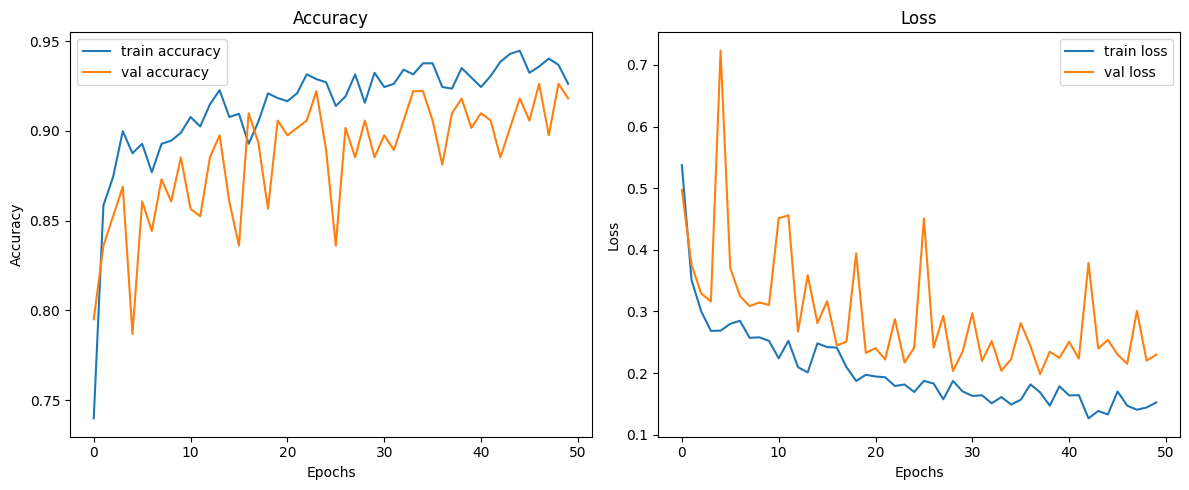

In [9]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


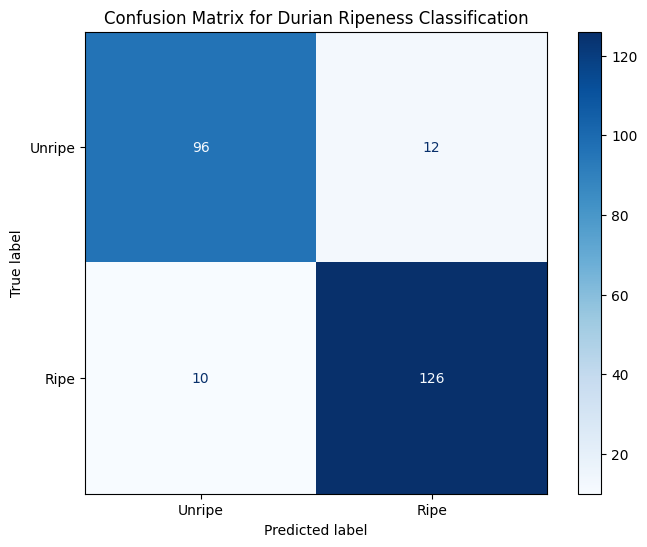

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate predictions for the test set
y_pred_probs = model.predict(X_test)  # Model outputs probabilities
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unripe', 'Ripe'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix for Durian Ripeness Classification")
plt.show()

In [12]:
# Save the model to /kaggle/working directory
model.save('/kaggle/working/Durian_ripeness_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


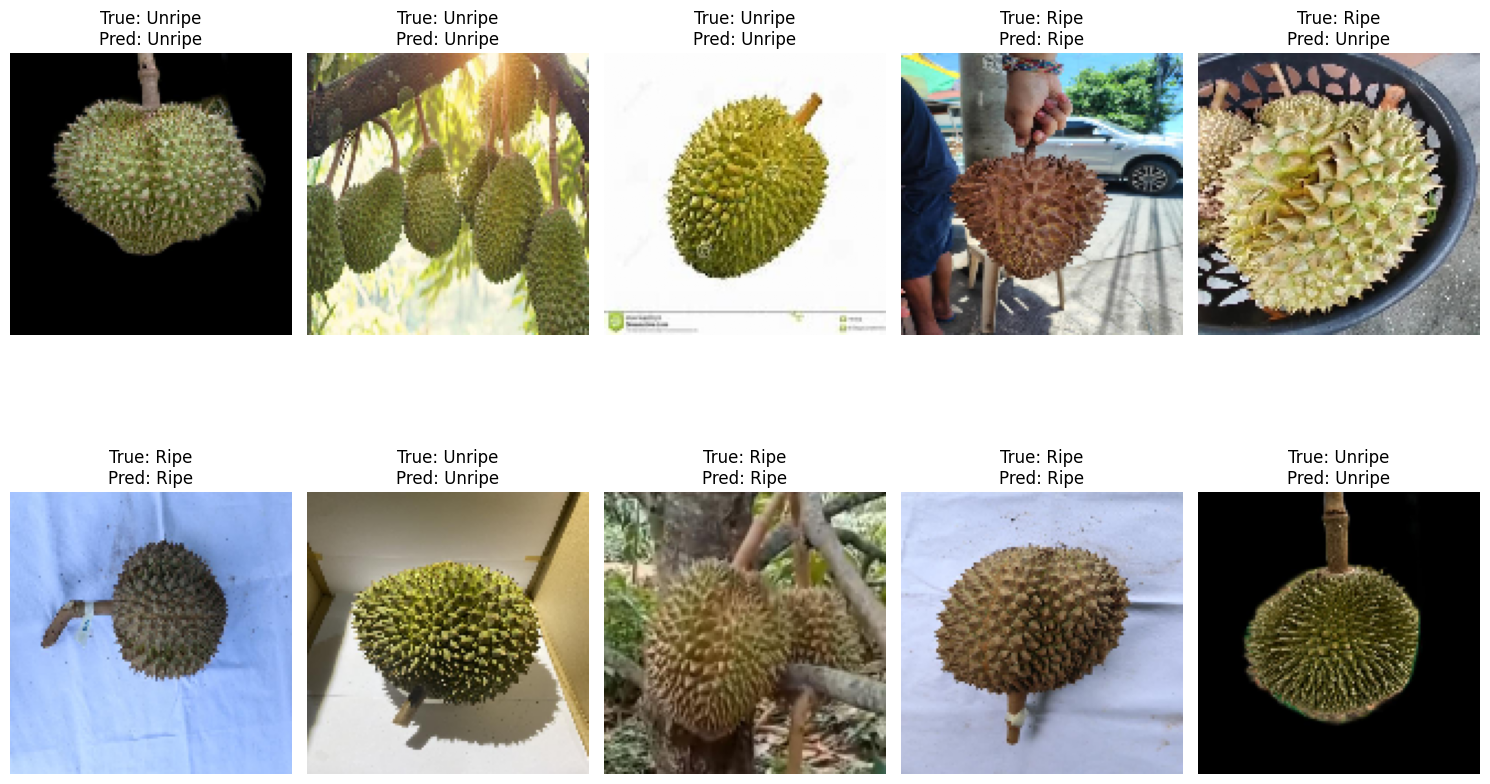

In [13]:
# Pick 10 random indices from the test set
random_indices = np.random.choice(len(X_test), 10, replace=False)

# Prepare the figure to plot the images
plt.figure(figsize=(15, 10))

# Iterate over the 10 random images
for i, idx in enumerate(random_indices):
    # Get the image and its true label
    img = X_test[idx]
    true_label = y_test[idx]
    
    # Make a prediction for the image
    img_expanded = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img_expanded)
    predicted_label = (prediction > 0.5).astype(int)  # Sigmoid activation, threshold at 0.5
    
    # Plot the image
    plt.subplot(2, 5, i+1)  # Arrange in 2 rows and 5 columns
    plt.imshow(img)
    plt.axis('off')
    
    # Set title with the true and predicted labels
    plt.title(f"True: {'Ripe' if true_label == 1 else 'Unripe'}\nPred: {'Ripe' if predicted_label == 1 else 'Unripe'}")

# Show the plot
plt.tight_layout()
plt.show()